### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
import os
from datetime import datetime

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
# Debug print flag 

DEBUG = False

#### Tracking the state-action pairs for checking convergence


In [4]:
def to_string(state_or_action):
    return ('-'.join(str(e) for e in state_or_action))

In [5]:
def initialise_tracking_states(state_space, action_space):
    for state in state_space:
        for action in action_space:
            state_str = to_string(state)
            action_str = to_string(action)
            States_track[state_str][action_str] = []

In [6]:
def save_tracking_states(curr_state, curr_action, q_value):
    for state in States_track.keys():
        if state == curr_state:
            for action in States_track[state].keys():
                if action == curr_action:
                    States_track[state][action].append(q_value)

In [7]:
# #Defining a function to save the Q-dictionary as a pickle file
# def save_obj(obj, name ):
#     with open(name + '.pkl', 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size, action_space):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.action_space = action_space

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001       
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.00065 #0.999
        self.epsilon_min = 0
        
        self.batch_size = 32    
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        # model.summary() 
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_epsilon(self, time):
        return self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*time)

    def get_action(self, state, time):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       

        epsilon = self.get_epsilon(time)

        possible_actions_index, all_possible_actions = env.requests(state)

        if len(possible_actions_index) == 0:
            return all_possible_actions[0]

        if (np.random.rand() <= epsilon):
            return random.choice(all_possible_actions)
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            state = env.state_encod_arch1(state)
            state = state.reshape(1, self.state_size)
            q_values = self.model.predict(state)[0]
            
            argmax = np.argmax(q_values[possible_actions_index])
#             DEBUG and print(f'q_values: {q_values}, available_q_vals: {q_values[possible_actions_index]}, argmax: {argmax}, all_possible_actions: {all_possible_actions}')
            return all_possible_actions[argmax]

    def append_sample(self, state, action, reward, next_state, isTerminal):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, isTerminal))
    
    def get_q_values(self, state):
        return self.model.predict(state)[0]
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, terminal_states  = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, isTerminal = mini_batch[i]
                # Write your code from here
                # 1. Predict the target from earlier model
                update_input[i] = env.state_encod_arch1(state).reshape(1, self.state_size)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state).reshape(1, self.state_size)   
                terminal_states.append(isTerminal)
                
            # 2. Get the target for the Q-network
            target = self.model.predict(update_input)
            target_qval = self.model.predict(update_output)
            
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                action_idx = action_space.index(actions[i])
                if terminal_states[i]:                    
                    target[i][action_idx] = rewards[i]
                else: # non-terminal state
                    target[i][action_idx] = rewards[i] + self.discount_factor * np.max(target_qval[i])                    
                    
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)

In [9]:
Episodes = 1000

env = CabDriver()
action_space, state_space, state = env.reset()
action_size = len(action_space)
state_size = len(env.state_encod_arch1(state_space[0]))

agent = DQNAgent(state_size, action_size, action_space)

States_track = collections.defaultdict(dict)
initialise_tracking_states(state_space, action_space)

# create folder with current time stamp
DIR_NAME = os.path.join(
        os.getcwd(), 
        'model-' + datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(DIR_NAME)

agent.epsilon_decay = 80.0/(Episodes * 10)

scores = {}

start_time = time.time()

### DQN block

In [10]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    

    #Call the DQN agent

    day = 0
    score = 0
    terminal_state = False

    # reset the state before new episode
    _, _, state = env.reset()
    initial_state = state
        
    while not terminal_state:        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        
        action = agent.get_action(state, episode)

        # 2. Evaluate your reward and next state
        next_state, reward = env.step(state, action, Time_matrix)
        
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        
        # increase the date if the day is changed
        if next_state[2] != state[2]:
            day = day + 1
        
        DEBUG and print(f'state: {state}, action: {action}, next_state: {next_state}, reward: {reward}, day: {day}')

        # for tracking
        state_enc = env.state_encod_arch1(state)
        state_enc = np.reshape(state_enc, [1, 36])
        q_values = agent.get_q_values(state_enc)
        
        state_string = to_string(state)
        
        for index in range(len(env.action_space)):
            action_string = to_string(env.action_space[index])
            save_tracking_states(state_string, action_string, q_values[index])
            
        if day > 30:
            terminal_state = True
            
        state = next_state

    print(f'Score {episode}: {score}')
    scores[episode] = score
    
    if ((episode + 1) % 10 == 0):
        agent.save(DIR_NAME + '\\' + str(episode) + '.h5')


elapsed_time = time.time() - start_time
print(f'Entire Operation took {elapsed_time} seconds')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

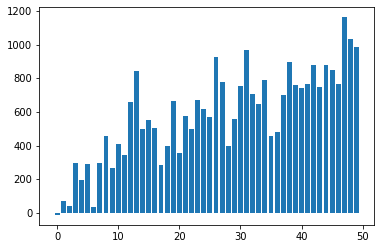

<Figure size 720x1440 with 0 Axes>

In [11]:
# plot score values

plt.bar(*zip(*scores.items()))
plt.figure(figsize=(10,20))
plt.show()

In [12]:
# save final model

agent.save(DIR_NAME + '\\final.h5')

### Tracking Convergence

In [13]:
States_track[1-2-0]

{}

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

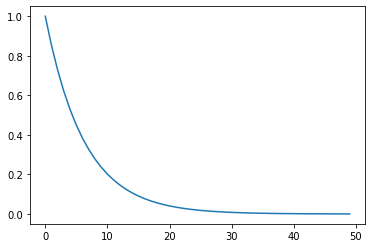

In [14]:
# time_arr = np.arange(0,1000)
epsilon = []
for i in range(0,Episodes):
    # epsilon.append(0 + (1 - 0) * np.exp(-0.0008*i))
    epsilon.append(agent.get_epsilon(i))

plt.plot(np.arange(0,Episodes), epsilon)
plt.show()

In [15]:
len(state_space)

840

In [16]:
a = [1, 2, 3]
